# 第六章 多元时间序列分析


- 如何理解ADF检验？
    - ADF的作用：判断序列的平稳性；判断不平稳序列属于哪种类型的不平稳，在延迟几阶的条件下会平稳
    - ADF的参数：
        - 方法 statsmodels.tsa.stattools.adfuller
        - 三种类型（对应 regression）：
            * 'c' : constant only (default)
            * 'ct' : constant and trend
            * 'ctt' : constant, and linear and quadratic trend
            * 'nc' : no constant, no trend
        - maxlag 与 autolag：  
            - 如果选择autolag时，意味着让程序进行参数选择；
            - 不选择autolag时，就会以maxlag计算ADF，也就是可以验证该阶延迟条件下是否平稳


- 如何理解 EG 校验？
    - EG校验作用：
        - ADF的扩展；ADF针对于单个序列；
        - EG针对于多个序列；验证多个序列之间的协整性
    - 协整性：类比概念是 单个序列的平稳性；当序列超过2个时，就是要验证多个序列之间的协整性；
    - 实现过程：
        - 输入序列去拟合输出序列后，残差是否平稳（此时对残差序列进行ADF校验） 





## 1 导入库

In [129]:
pwd

'/Users/pengju/python-workspace/statistics/应用时间序列分析'

In [1]:
import datetime
import pandas as pd
import numpy as np
import os
import matplotlib as  mpl

import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号




习题数据="./习题与案例数据/习题数据/"
案例数据="./习题与案例数据/案例数据/"

In [113]:
from statsmodels.tsa.stattools import acf,pacf,adfuller
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


## 2 例题6-1

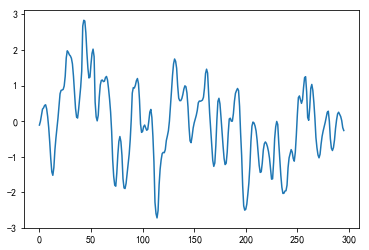

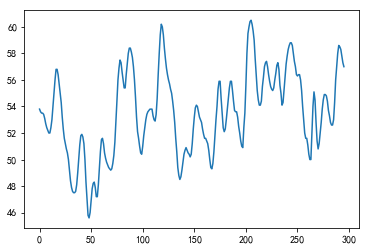

In [22]:
input =pd.Series(pd.read_excel(os.path.join(案例数据,"附录1.25.xls"),header=None,sheetname="输入序列").dropna(axis=0).values.flatten(),name='input')
output =pd.Series(pd.read_excel(os.path.join(案例数据,"附录1.25.xls"),header=None,sheetname="输出序列").dropna(axis=0).values.flatten(),name='output')

plt.plot(input)
plt.show()
plt.plot(output)
plt.show()

## 3 例题6-2  

In [119]:
# 生成adf校验表，判断序列是否平稳，类似参数书上P227；用来确定阶数
def adf_check_table(ts,max_lag,threshod=0.05):
    DICT_REGRESSION={'nc':'类型1',
                 'c':'类型2',
                 'ct':'类型3'}
    list_df=[]
    for i_reg in DICT_REGRESSION.keys():
        for i in range(max_lag+1):
            dftest=adfuller(ts,maxlag=i,regression=i_reg,autolag=None)
            dfoutput=pd.Series([DICT_REGRESSION[i_reg],i,'平稳' if dftest[1]<threshod else '非平稳']+list(dftest[0:4]),
                               index=['类型','延迟阶数','检验结果','Test Statistic','p-value','Lags Used',
            'Number of observations Used'])
            for key,value in dftest[4].items():
                dfoutput['Critical value(%s)'%key]=value
            list_df.append(dfoutput)
    return pd.concat(list_df,axis=1).transpose()
    
    
# 使用Q_LB进行白噪音假设
def my_Q_LB(ts,out_lags_list=[10],p_threshold=0.05):
    from scipy.stats  import  chi2
    n=len(ts)
    acf_ts=acf(ts,nlags=n)

    list_df=[]
    for l in out_lags_list:
        q_lb=sum([n*(n+2)*acf_ts[k]**2/(n-k)  for k in range(1,l+1) ])
        p=1- chi2.cdf(q_lb,l)
        tmp_l=[l,q_lb,p,p>p_threshold]
        list_df.append(tmp_l)

    df=pd.DataFrame(list_df,columns=['延迟期数','Q_LB统计量','P值','接受白噪音假设'])
    return df    
    

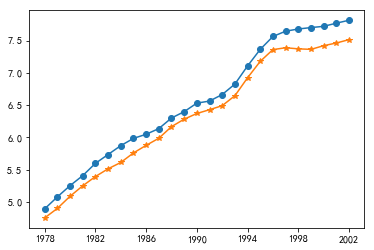

对数纯收入的ADF检验


,类型,延迟阶数,检验结果,Test Statistic,p-value,Lags Used,Number of observations Used,Critical value(1%),Critical value(5%),Critical value(10%)
0,类型1,0,非平稳,7.04974,1,0,24,-2.6652,-1.95578,-1.60863
1,类型1,1,非平稳,1.08593,0.92723,1,23,-2.66981,-1.95647,-1.60832
2,类型2,0,非平稳,-2.17779,0.214406,0,24,-3.73771,-2.99222,-2.63575
3,类型2,1,非平稳,-1.16065,0.690292,1,23,-3.75293,-2.9985,-2.63897
4,类型3,0,非平稳,-0.69806,0.973275,0,24,-4.39504,-3.61239,-3.24322
5,类型3,1,非平稳,-3.13805,0.0974683,1,23,-4.41715,-3.62219,-3.24873


对数生活消费支出的ADF检验


,类型,延迟阶数,检验结果,Test Statistic,p-value,Lags Used,Number of observations Used,Critical value(1%),Critical value(5%),Critical value(10%)
0,类型1,0,非平稳,6.5355,1,0,24,-2.6652,-1.95578,-1.60863
1,类型1,1,非平稳,1.08058,0.926562,1,23,-2.66981,-1.95647,-1.60832
2,类型2,0,非平稳,-2.27103,0.18148,0,24,-3.73771,-2.99222,-2.63575
3,类型2,1,非平稳,-1.40854,0.578174,1,23,-3.75293,-2.9985,-2.63897
4,类型3,0,非平稳,-0.457411,0.985013,0,24,-4.39504,-3.61239,-3.24322
5,类型3,1,非平稳,-3.31262,0.0642035,1,23,-4.41715,-3.62219,-3.24873


,类型,延迟阶数,检验结果,Test Statistic,p-value,Lags Used,Number of observations Used,Critical value(1%),Critical value(5%),Critical value(10%)
0,类型1,0,非平稳,-1.38089,0.155554,0,23,-2.66981,-1.95647,-1.60832
1,类型1,1,非平稳,-1.37013,0.158525,1,22,-2.67486,-1.95723,-1.60797
2,类型1,2,非平稳,-1.35688,0.162235,2,21,-2.68043,-1.95805,-1.60759
3,类型1,3,非平稳,-1.33662,0.168022,3,20,-2.6866,-1.95894,-1.60715
4,类型2,0,非平稳,-1.91763,0.323812,0,23,-3.75293,-2.9985,-2.63897
5,类型2,1,非平稳,-2.22669,0.196701,1,22,-3.76973,-3.00543,-2.6425
6,类型2,2,平稳,-3.09644,0.0268178,2,21,-3.78839,-3.0131,-2.6464
7,类型2,3,非平稳,-1.89676,0.333585,3,20,-3.80921,-3.02165,-2.65071
8,类型3,0,非平稳,-2.07695,0.558979,0,23,-4.41715,-3.62219,-3.24873
9,类型3,1,非平稳,-2.40955,0.374552,1,22,-4.44161,-3.63298,-3.25479


,类型,延迟阶数,检验结果,Test Statistic,p-value,Lags Used,Number of observations Used,Critical value(1%),Critical value(5%),Critical value(10%)
0,类型1,0,非平稳,-1.26832,0.188551,0,23,-2.66981,-1.95647,-1.60832
1,类型1,1,非平稳,-1.79671,0.0688157,1,22,-2.67486,-1.95723,-1.60797
2,类型1,2,非平稳,-1.30473,0.177412,2,21,-2.68043,-1.95805,-1.60759
3,类型1,3,非平稳,-1.05818,0.261404,3,20,-2.6866,-1.95894,-1.60715
4,类型2,0,非平稳,-1.89413,0.334825,0,23,-3.75293,-2.9985,-2.63897
5,类型2,1,平稳,-3.34751,0.0128839,1,22,-3.76973,-3.00543,-2.6425
6,类型2,2,非平稳,-2.80883,0.0570238,2,21,-3.78839,-3.0131,-2.6464
7,类型2,3,非平稳,-1.71717,0.422287,3,20,-3.80921,-3.02165,-2.65071
8,类型3,0,非平稳,-2.15647,0.514367,0,23,-4.41715,-3.62219,-3.24873
9,类型3,1,平稳,-3.62337,0.0279256,1,22,-4.44161,-3.63298,-3.25479


参数为纯收入    0.968316
dtype: float64
对数生活消费支出 和 对数纯收入 的EG 校验 


,类型,延迟阶数,检验结果,Test Statistic,p-value,Lags Used,Number of observations Used,Critical value(1%),Critical value(5%),Critical value(10%)
0,类型1,0,非平稳,-1.33315,0.169027,0,24,-2.6652,-1.95578,-1.60863
1,类型1,1,平稳,-1.69255,0.0857267,1,23,-2.66981,-1.95647,-1.60832
2,类型1,2,平稳,-1.92757,0.0514654,2,22,-2.67486,-1.95723,-1.60797
3,类型2,0,非平稳,-1.27774,0.639296,0,24,-3.73771,-2.99222,-2.63575
4,类型2,1,非平稳,-1.64376,0.460299,1,23,-3.75293,-2.9985,-2.63897
5,类型2,2,非平稳,-1.85101,0.355447,2,22,-3.76973,-3.00543,-2.6425
6,类型3,0,非平稳,-1.34568,0.876161,0,24,-4.39504,-3.61239,-3.24322
7,类型3,1,非平稳,-1.7221,0.741058,1,23,-4.41715,-3.62219,-3.24873
8,类型3,2,非平稳,-1.85518,0.677561,2,22,-4.44161,-3.63298,-3.25479


模型定阶： 1阶自相关


,延迟期数,Q_LB统计量,P值,接受白噪音假设
0,5,3.651612,0.600581,True
1,10,6.950229,0.730135,True
2,15,17.422737,0.294227,True


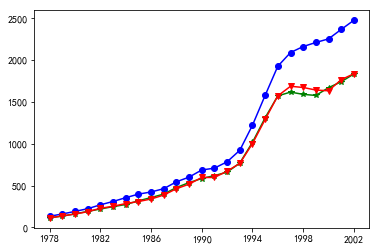

In [127]:
# 读取数据
家庭收入消费= pd.read_excel(os.path.join(案例数据,"附录1.26.xls")).dropna()[['年份','纯收入','生活消费支出']].set_index('年份')
家庭收入消费.index=[datetime.datetime(int(i),1,1) for i in 家庭收入消费.index]
纯收入=家庭收入消费['纯收入']
生活消费支出=家庭收入消费['生活消费支出']
对数纯收入=np.log(家庭收入消费['纯收入'])
对数生活消费支出=np.log(家庭收入消费['生活消费支出'])
plt.plot(对数纯收入,marker='o')
plt.plot(对数生活消费支出,marker='*')
plt.show()

# 进行ADF检验
print("对数纯收入的ADF检验")
display(adf_check_table(对数纯收入,max_lag=1))

print("对数生活消费支出的ADF检验")
display(adf_check_table(对数生活消费支出,max_lag=1))

# 进行差分后再进行ADF检验
对数纯收入_diff=对数纯收入.diff().dropna()
display(adf_check_table(对数纯收入_diff,max_lag=3))

对数生活消费支出_diff=对数生活消费支出.diff().dropna()
display(adf_check_table(对数生活消费支出_diff,max_lag=3))

# 协整校验 EG 校验 构造回归模型 
model = sm.OLS(endog=对数生活消费支出,exog=对数纯收入)
results = model.fit()
print("参数为{}".format( results.params))
残差序列=results.resid
print("对数生活消费支出 和 对数纯收入 的EG 校验 ")
display(adf_check_table(残差序列,max_lag=2,threshod=0.1))
print("模型定阶： 1阶自相关")

# 
model=SARIMAX(endog=对数生活消费支出,exog=对数纯收入,order=(1,0,0),trend='n')
results=model.fit()
残差序列=results.resid
display(my_Q_LB(残差序列,out_lags_list=[5,10,15]))
预测值=results.fittedvalues
exp_预测值=np.exp(预测值)
plt.plot(纯收入,marker='o',color='b')
plt.plot(生活消费支出,marker='*',color='g')
plt.plot(exp_预测值,marker='v',color='r')
plt.show()


